### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w

!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

data = pd.read_json("./arxivData.json")

BOS, EOS = ' ', '\n'
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

--2024-10-04 15:30:46--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/0mulrothty5o8i8ud9gz2/arxivData.json.tar.gz?rlkey=n759u5qx2xpxxglmrl390vwvk&dl=1 [following]
--2024-10-04 15:30:47--  https://www.dropbox.com/scl/fi/0mulrothty5o8i8ud9gz2/arxivData.json.tar.gz?rlkey=n759u5qx2xpxxglmrl390vwvk&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca5072321b904e3b7adf0698bf4.dl.dropboxusercontent.com/cd/0/inline/Cb3fV-UOMTIjWiTzL6m8nakFs6yhj2SEajjl-t0aLZVHl8ZumzQ66A0XRWL2SJxgnFkWMWciWJ9def9MZOCqxeUh3PZsY3PzCvRsJkMrVFPKCcBpAovPwmf7znXMsy_e_zE/file?dl=1# [following]
--2024-10-04 15:30:48--  https://uca5072321b904e3b7adf0698bf4.dl.dropbox

In [3]:
sorted(lines, key=len)[:3]

[' Differential Contrastive Divergence ; This paper has been retracted.\n',
 ' What Does Artificial Life Tell Us About Death? ; Short philosophical essay\n',
 ' P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.\n']

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [4]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(' '.join(lines))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [5]:
# dictionary of character -> its identifier (index in tokens list)

token_to_id = dict(zip(tokens, np.arange(n_tokens)))
# token_to_id = dict((k,v) for v,k in enumerate(tokens))

print(token_to_id)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, '`': 65, 'a': 66, 'b': 67, 'c': 68, 'd': 69, 'e': 70, 'f': 71, 'g': 72, 'h': 73, 'i': 74, 'j': 75, 'k': 76, 'l': 77, 'm': 78, 'n': 79, 'o': 80, 'p': 81, 'q': 82, 'r': 83, 's': 84, 't': 85, 'u': 86, 'v': 87, 'w': 88, 'x': 89, 'y': 90, 'z': 91, '{': 92, '|': 93, '}': 94, '~': 95, '\x7f': 96, '°': 97, 'É': 98, 'Ö': 99, 'Ü': 100, 'à': 101, 'á': 102, 'â': 103, 'ã': 104, 'ä': 105, 'æ': 106, 'ç': 107, 'è': 108, 'é': 109, 'ê':

In [6]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [7]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [8]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
emb_size = 16
hid_size = 64
window_size=5
dummy_lines_matrix = torch.tensor(to_matrix(dummy_lines), device=device)

print(dummy_lines)
print(dummy_lines_matrix)
print(dummy_lines_matrix.shape)

strides = dummy_lines_matrix.shape[1]
emb = torch.nn.Embedding(n_tokens, emb_size,device=device)
pad = torch.nn.ZeroPad2d((window_size-1,0,0,0))
conv = torch.nn.Conv1d(emb_size, hid_size, kernel_size=window_size,padding=0, device=device)
conv2 = torch.nn.Conv1d(hid_size, hid_size, kernel_size=window_size,padding=0, device=device)
# out = torch.nn.Linear(hid_size, n_tokens)
out = torch.nn.Conv1d(hid_size, n_tokens, kernel_size=1,padding=0, device=device)

lines_emb = emb(dummy_lines_matrix)
lines_emb = lines_emb.transpose(2, 1)

print(lines_emb.shape)

lines_pad = pad(lines_emb)
lines_conv = conv(lines_pad)
lines_relu = F.relu(lines_conv)

print(lines_pad.shape)
print(lines_conv.shape)
print(lines_relu.shape)

lines_pad2 = pad(lines_relu)
lines_conv2 = conv2(lines_pad2)
lines_relu2 = F.relu(lines_conv2)

print(lines_pad2.shape)
print(lines_conv2.shape)
print(lines_relu2.shape)


lines_pad3 = pad(lines_relu2)
lines_conv3 = conv2(lines_pad3)
lines_relu3 = F.relu(lines_conv3)

print(lines_pad3.shape)
print(lines_conv3.shape)
print(lines_relu3.shape)

# lines_linear = lines_relu3.transpose(1,2)
# print(lines_linear.shape[0])
# print(lines_linear.shape[1])

# nr,nc,c = lines_linear.shape
# lines_linear = lines_relu3.reshape(nr*nc, 64)

# print(lines_linear.shape)
lines_linear = out(lines_relu3)
print(lines_linear.shape)
# lines_linear = lines_linear.reshape(nr,nc,n_tokens)
lines_linear = lines_linear.transpose(1,2)
print(lines_linear.shape)


# print(lines_emb)
# print(lines_pad)



[' abc\n', ' abacaba\n', ' abc1234567890\n']
tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]],
       device='cuda:0')
torch.Size([3, 15])
torch.Size([3, 16, 15])
torch.Size([3, 16, 19])
torch.Size([3, 64, 15])
torch.Size([3, 64, 15])
torch.Size([3, 64, 19])
torch.Size([3, 64, 15])
torch.Size([3, 64, 15])
torch.Size([3, 64, 19])
torch.Size([3, 64, 15])
torch.Size([3, 64, 15])
torch.Size([3, 136, 15])
torch.Size([3, 15, 136])


In [12]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64, window_size=5):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)

        self.emb_size = emb_size
        self.emb = torch.nn.Embedding(n_tokens, self.emb_size, device=device)
        self.pad = torch.nn.ZeroPad1d((window_size-1, 0,0,0))
        self.conv = torch.nn.Conv1d(self.emb_size, hid_size, kernel_size=window_size, padding=0, device=device)
        self.conv2 = torch.nn.Conv1d(hid_size, hid_size, kernel_size=window_size,padding=0, device=device)
        # self.out = torch.nn.Linear(hid_size, n_tokens)
        self.out = torch.nn.Conv1d(hid_size, n_tokens, kernel_size=1,padding=0,device=device)
        self.to(device)



        #END OF YOUR CODE

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above

        # n_rows,n_columns = input_ix.shape

        lines_emb = self.emb(input_ix)
        lines_emb = lines_emb.transpose(2, 1)

        lines_pad = self.pad(lines_emb)
        lines_conv = self.conv(lines_pad)
        lines_relu = F.relu(lines_conv)

        lines_pad2 = self.pad(lines_relu)
        lines_conv2 = self.conv2(lines_pad2)
        lines_relu2 = F.relu(lines_conv2)


        lines_pad3 = self.pad(lines_relu2)
        lines_conv3 = self.conv2(lines_pad3)
        lines_relu3 = F.relu(lines_conv3)

        lines_linear = self.out(lines_relu3)
        lines_linear = lines_linear.transpose(1,2)

        # print(lines_linear.shape)

        return lines_linear # output tensor should be of shape [batch_size, sequence_length, n_tokens]


    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64,device=device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [13]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device=device)
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'conv2.weight', 'conv2.bias', 'out.weight', 'out.bias')


In [14]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [15]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device=device)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [16]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [17]:
dummy_input_ix1 = torch.as_tensor(to_matrix(dummy_lines, max_len=15), device=device)
dummy_input_ix2 = torch.as_tensor(to_matrix(dummy_lines, max_len=16),device=device)
mask1 = compute_mask(dummy_input_ix1).to(torch.int32).cpu().numpy().astype(bool)
mask2 = compute_mask(dummy_input_ix2).to(torch.int32).cpu().numpy().astype(bool)


print('matrix:\n', dummy_input_ix1.cpu().numpy())
print('logits shape: \n', dummy_model(dummy_input_ix1).shape)
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

print('matrix:\n', dummy_input_ix2.cpu().numpy())
print('logits shape: \n', dummy_model(dummy_input_ix2).shape)
print('mask:', compute_mask(dummy_input_ix2).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix2).sum(-1).cpu().numpy())

for i in range(len(dummy_input_ix)):
  print(dummy_input_ix.cpu().numpy()[i][mask1[i]].shape)
  print(dummy_input_ix2.cpu().numpy()[i][mask2[i]].shape)

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
logits shape: 
 torch.Size([3, 15, 136])
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]
matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0  0]]
logits shape: 
 torch.Size([3, 16, 136])
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]]
lengths: [ 5  9 15]
(5,)
(5,)
(9,)
(9,)
(15,)
(15,)


In [18]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64,device=device)

    # print('input shape: ',input_ix.shape)
    batch_size, seq_len = input_ix.shape

    logits = model(input_ix)
    reference_answers = input_ix[:, 1:]

    # print('logits shape: ',logits.shape)
    # print('ref shape: ', reference_answers.shape)
    # print(data_len)



    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.

    mask = compute_mask(input_ix).to(torch.int32).cpu().numpy().astype(bool)
    # print('mask ',mask.astype(int))
    loss = 0


    for i in range(batch_size):
        true_logits = logits[i][mask[i]]
        # print(torch.sum(true_logits,dim=1))
        # print('masked_logits',true_logits.shape)
        seq_len = true_logits.shape[0]
            # print(true_logits)
            # prefix = input_ix[i][:j+1]
            # logits = model(torch.tensor([prefix]))
        with torch.no_grad():
            probs = torch.softmax(true_logits, dim=-1)
            # print(probs.shape)
            # print('\n')
        for j in range(seq_len):
            prob = probs[j][reference_answers[i][j-1]]
            # print(reference_answers[i][j])
            # print(probs[j][reference_answers[i][j]])
            # print(prob)
            loss += -torch.log(prob)

    # print(loss)
    loss /= batch_size




    # return loss
    return torch.tensor(loss, requires_grad=True)



In [19]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input_ix: int64 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64,device=device)
    batch_size, seq_len = input_ix.shape

    # print('input shape: ',input_ix.shape)

    # Get model predictions (logits) for the entire sequence
    logits = model(input_ix[:, :-1])  # logits: [batch_size, seq_len, n_tokens]
    reference_answers = input_ix[:, 1:]  # target is the next token in the sequence
    # logits = logits[:, :-1, :]  # align logits with targets (since we're predicting next token)

    # print('logits shape: ',logits.shape)
    # print('ref shape: ', reference_answers.shape)

    # Compute the mask to exclude padding and subsequent EOS tokens
    mask = compute_mask(input_ix)[:, 1:]  # [batch_size, seq_len-1]
    # print('mask', mask.to(torch.int32))


    # Compute the softmax probabilities for each sequence and each position
    softmax_probs = torch.softmax(logits, dim=-1)  # [batch_size, seq_len-1, n_tokens]

    # Gather the probabilities of the correct target tokens for each sequence
    batch_losses = []
    nll_loss = 0

    for i in range(batch_size):
        masked_logits = softmax_probs[i][mask[i]]  # valid logits for sequence i
        # print('masked_logits',masked_logits.shape)

        masked_targets = reference_answers[i][mask[i]]  # valid targets for sequence i
        # print('masked_targets',masked_targets.shape)

        target_probs = masked_logits.gather(1, masked_targets.unsqueeze(-1)).squeeze(-1)
        # print('target_probs',target_probs)
        nll_loss += -torch.sum(torch.log(target_probs + 1e-50)) # avoid log(0)
        # batch_losses.append(nll_loss.mean())  # mean loss for this sequence

    # return torch.stack(batch_losses).mean()
    nll_loss = nll_loss/batch_size
    # print('nll_loss',nll_loss)
    return nll_loss


In [20]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [21]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            batch_ix = torch.as_tensor(batch_ix, dtype=torch.int64,device=device)
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [27]:
# print(blobdy)
device

'cuda'

In [28]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingC[àq\ŁUqcèś9\βiAχ/τ=°Y]Cτ o5ρA°âjOkσã$



In [24]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


  0%|          | 2/1000 [01:02<8:41:34, 31.36s/it]


KeyboardInterrupt: 

In [25]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

AssertionError: The model didn't converge.

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [22]:
emb_size=16
hid_size=256
num_layers = 2

dummy_lines_matrix = torch.tensor(to_matrix(dummy_lines), device=device)
# dummy_lines_matrix = torch.randint(0, n_tokens, (3, 15))
batch_size, sequence_length = dummy_lines_matrix.shape


print(dummy_lines)
print(dummy_lines_matrix)
print(dummy_lines_matrix.shape)
emb = torch.nn.Embedding(n_tokens, emb_size, device=device)
lstm = torch.nn.LSTM(emb_size, hid_size, num_layers=num_layers,batch_first=True, device=device)

h0 = torch.zeros((num_layers, batch_size, hid_size),device=device)
c0 = torch.zeros((num_layers, batch_size, hid_size),device=device)



lines_emb = emb(dummy_lines_matrix)
lines_lstm, hidden = lstm(lines_emb, (h0,c0))

print(lines_emb.shape)
print(lines_lstm.shape)
print(hidden[0].shape)
print(hidden[1].shape)

[' abc\n', ' abacaba\n', ' abc1234567890\n']
tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]],
       device='cuda:0')
torch.Size([3, 15])
torch.Size([3, 15, 16])
torch.Size([3, 15, 256])
torch.Size([2, 3, 256])
torch.Size([2, 3, 256])


In [23]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256, num_layers=2):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables/etc
        self.emb_size = emb_size
        self.num_layers=num_layers
        self.emb = torch.nn.Embedding(n_tokens, self.emb_size, device=device)
        self.lstm = torch.nn.LSTM(emb_size, hid_size, num_layers=self.num_layers, batch_first=True,device=device)
        self.fc = nn.Linear(hid_size, n_tokens,device=device)
        # self.to(device)


        #END OF YOUR CODE

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        batch_size, seq_length = input_ix.shape

        h0 = torch.zeros((self.num_layers, batch_size, hid_size), device=device)
        c0 = torch.zeros((self.num_layers, batch_size, hid_size), device=device)
        hidden = (h0,c0)

        lines_emb = self.emb(input_ix)
        lines_lstm, hidden = self.lstm(lines_emb, hidden)
        lines_out = self.fc(lines_lstm)


        return lines_out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.lstm.num_layers, batch_size, self.lstm.hidden_size).zero_(),
                weight.new(self.lstm.num_layers, batch_size, self.lstm.hidden_size).zero_())

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [24]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device=device)
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias')


In [25]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device=device)
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [29]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 64
score_dev_every = 250
train_history, dev_history = [], []
model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingüpFAXΣ-ï)^MνőïBê-γFj>IM[τwédα|U uőãN+9ZβQ;Π+μâλ/TKHμS0ÖLνbIióKS]GÉbçn9*σ°ω%é:ν{1ôgεωf^6εuQêæ


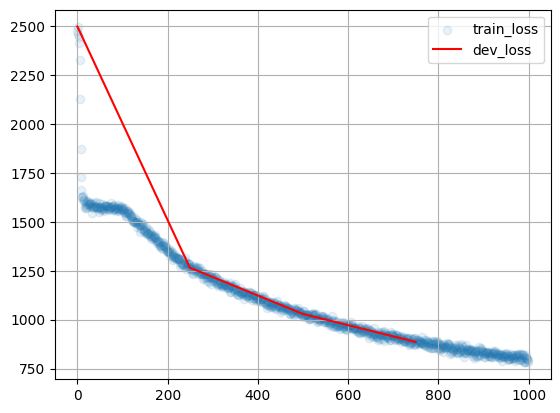

Generated examples (tau=0.5):
 A Selational Anservent Metrod Matter Recognition ; The state studies and the problem for implication
 A Singues ; This paper models and stative space such a structure the set is incontence on the setter
 Anvaulition of Discriction For sympress for vide a method been with is of the conver be have deficit
Scoring dev...


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]

#999 Dev loss: 796.010


In [30]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 1000):
    batch = to_matrix(sample(train_lines, batch_size))

    # <YOUR CODE - one step of the training loop for your RNN model>

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [31]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 796.0098764172066
 A Recognal Content Antrolutional Contive Learning ; We propent selication of image the interent a sh
 Information ; We are eno convers and the spect of complement and compute the sparse of the generatio
 A simple Insception is a conters both in the propose ; We process the structions in the space of the
 Simigation ; The propose to a commons and make and the problem of the present to the experetic perfo
 Deep furtion and Reconsition of Complect for Suman Seart Network in stuctor and Network of for Mad M
 An Singly to Context Network ; This paper we such and a segting and network that expert complexity t
 A Dimension of intermong Estain Mersed ; The distribution of the a neural propose a new the the envi
 A selting and the compare and To a computation to show the neural convolutional proment in the Doce 
 Semantic Lotion ; The present as a constanding Martive a multing a non the dimensional in a state th
 Segent Anternant Spect Struction ; Discrent fra

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [32]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs=np.array(probs)
        # print(probs.shape)
        prob=0
        k=0
        probs_sorted = np.argsort(probs)[::-1]
        # print(probs_sorted)
        while prob < nucleus:
            prob += probs[probs_sorted[k]]
            k+=1
            if k == len(probs):
                break
        probs[probs_sorted[k:]]=0
        probs = probs/sum(probs)
        # print(probs)
        next_token = np.random.choice(tokens, p=probs)
        # print(next_token)

        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [50]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.9))

 ναl nrn  so aeoosnfoil tittl  ngo topeossne tasoed nsc godtae srt a a sai oiornnflnint hoii msapoatn
 iqhrlnsnnfoopuemn e he fpnc rh ioa d adnettnnia cat nrrn  empneneaeesftplomlnthr h es in peensntnlly
 É)Bttdrorgietn  eeoipteo  ti eeenipongittmteorle e r npneaca l na  hhistmtge e e sie nn teepdd gsi a
 S- iaerenttnoipnmtosnc roag ieeiaa  ii iamentieoyaoueep  eoehsaora t nt oe tr nn tsii sieldmihla tnt
 mW.sge  fhr amttntnsr sorlgn ntoeisshte ad depaaousnaae sdcsi oluadamsgceye sadisssmi gaarodtahmiiol
 Z;irsorythradrtri titnpaino hu ie nnio iacetclhiecnerr oaapineher pct a unea oteiriarn n h uuedusrii
 ä-ps afeepitoisdt   utau ateieareteoci haerisols o   h ayrss ichdnocpp  uton  rengtstg fate r matlee
 Éod bdsarn raf  ncmeuul ateoo  ohaild igee  shrcoooh  leeresro oet tuehietshphnprcsnaameeeupigeintrs
 eTd onaid un iaeuir r acmrom  tsa ra guesog a  fn mpecntn emp ntm arint sc yisndye guihs oearnae rse
 äWcrem taiegif  y ilo mnstrrhddherg  a  oi  et yrtef eo  thtuf au ii lmd  eentut 

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it.

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [ ]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [40]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, max_len=5):
    beam_tokens = [prefix]
    beam_probs = [1.0]

    c = 0

    while True:
        all_candidates = []

        for i in range(len(beam_tokens)):
            token_probs = model.get_possible_next_tokens(beam_tokens[i])
            tokens, probs = zip(*token_probs.items())

            tokens = np.array(tokens)
            probs = np.array(probs)
            log_probs = np.log(probs + 1e-9) + np.log(beam_probs[i])

            for j in range(len(tokens)):
                new_candidate = (beam_tokens[i] + tokens[j], log_probs[j])
                all_candidates.append(new_candidate)

        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beam_tokens = [x[0] for x in all_candidates[:beam_size]]
        beam_probs = [np.exp(x[1]) for x in all_candidates[:beam_size]]

        c += 1
        # print('iteration:', c)
        # print(beam_tokens)
        # print(beam_probs)

        if all([len(t) >= max_len or t.endswith(EOS) for t in beam_tokens]):
            break

    return beam_tokens, beam_probs


In [41]:
generate_beamsearch(model, prefix=' deep ', beam_size=4, max_len=15)

([' deep Networks ', ' deep Network ;', ' deep Neural Ne', ' deep Network f'],
 [0.0041599823, 0.0015313829, 0.0007323639, 0.0006562173])

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_